# model

## Install package

In [1]:
### download pylon folder and change file path !

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
! pip install --upgrade albumentations

     |████████████████████████████████| 102 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 46.3 MB 2.5 MB/s eta 0:00:011 MB 4.1 MB/s eta 0:00:11


In [4]:
!pip uninstall opencv-python-headless==4.5.5.62 -y

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64


In [5]:
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 43.6 MB 4.0 MB/s eta 0:00:01


In [6]:
!pip install python-gdcm pydicom

     |████████████████████████████████| 11.4 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 5.2 MB/s eta 0:00:01


In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Resize
from torchvision.io import read_image, ImageReadMode
# import torchmetrics
import torch.nn.functional as F
import numpy as np

print(torch.__version__)

1.11.0


In [8]:
from albumentations import HorizontalFlip, Rotate, RandomBrightnessContrast, Flip, Compose, RandomResizedCrop
from typing import List, Optional, Dict, Generator, NamedTuple, Any, Tuple, Union, Mapping

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from multiprocessing import Pool

In [10]:
import gc
import math
from tqdm import tqdm
import time

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cpu device


## Set parameter

In [12]:
epochs = 50

labels_col = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Pneumothorax', 'Edema']
classes = 5 # number of findings
image_w = 256
image_h = 256
batch_size = 32

## Create PyTorch Dataset

In [13]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def dicom2array(path, voi_lut=True, fix_monochrome=True):
    """Convert DICOM file to numy array
    
    Args: 
        path (str): Path to the DICOM file to be converted
        voi_lut (bool): Whether or not VOI LUT is available
        fix_monochrome (bool): Whether or not to apply MONOCHROME fix
        
    Returns:
        Numpy array of the respective DICOM file
    """
    
    # Use the pydicom library to read the DICOM file
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # Depending on this value, X-ray may look inverted - fix that
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    # Normalize the image array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

In [14]:
class XRayDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, target_transform=None):
      self.img_files = df['Image'].tolist()
      self.img_labels = df[labels_col].values
      self.transform = transform
      self.target_transform = target_transform
      self.image_dir = image_dir

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      img_path = os.path.join(self.image_dir, self.img_files[idx])
      if '.dcm' in self.img_files[idx]:
        image = dicom2array(img_path)
        image = torch.tensor(image)/255
        image = image.unsqueeze(0)
      else:
        image = read_image(img_path, mode=ImageReadMode.GRAY)/255

      label = self.img_labels[idx]
      if self.transform:
          image = image[0].numpy()
          aug = self.transform(image=image)
          image = torch.from_numpy(aug["image"])
          image = image.unsqueeze(0)
      image = image.unsqueeze(0)
      image = F.interpolate(image, size=image_w)
      image = image[0]
      # image = image.expand(3, -1, -1)
      return image, label

In [15]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [16]:
def augment(p=0.5):
    return Compose([
        RandomResizedCrop(image_h,image_w,scale=(0.7, 1.0), p=1.0),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(0.5,0.5,p=0.5),
        Rotate(90, border_mode=0, p=0.5),
    ], p=p)
augmentation = augment()

In [17]:
site_name = 'chula' # edit
sites = ['chula', 'nih', 'padchest', 'mimic', 'vin']
col_list = ['Image', 'Atelectasis', 'Cardiomegaly', 'Edema', 'Effusion', 'Pneumothorax']
labels_col = col_list[1:]

site_path = 'data/data_' + site_name
IMAGE_PATH = site_path + '/image'

# train and val from 1 site
train = pd.read_csv(site_path + '/train_' + site_name + '.csv')
val = pd.read_csv(site_path + '/val_' + site_name + '.csv')

# test from all sites
test = pd.DataFrame(columns=col_list)
for s in sites:   
    df = pd.read_csv('data/data_' + s + '/test_' + s + '.csv')
    df['Image'] = df['Image'].apply(lambda x: 'data/data_' + s + '/image/' + x)
    test = pd.concat([test,df],axis=0)
test = test.sample(frac=1).reset_index(drop=True)
test

,Image,Atelectasis,Cardiomegaly,Effusion,Pneumothorax,Edema
0,20210102CR0073.png,0.0,1.0,0.0,0.0,0.0
1,20210102CR0154.png,0.0,1.0,1.0,0.0,1.0
2,20210102CR0185.png,0.0,0.0,0.0,0.0,0.0


In [18]:
train_dataset = XRayDataset(train, IMAGE_PATH, transform=augmentation)
valid_dataset = XRayDataset(val, IMAGE_PATH)
test_dataset = XRayDataset(test, IMAGE_PATH)

[0. 0. 0. 0. 0.]
torch.Size([1, 256, 256])


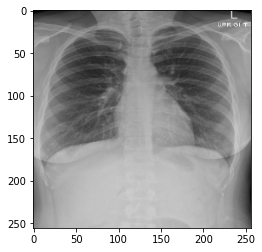

In [19]:
image, label = train_dataset[2]
print(label)
print(image.size())
plt.imshow(image[0], cmap='gray')

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## PYLON

### import model

In [21]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 88 kB 1.7 MB/s eta 0:00:01
  Using cached efficientnet_pytorch-0.6.3.tar.gz (16 kB)
  Using cached timm-0.4.12-py3-none-any.whl (376 kB)
  Using cached pretrainedmodels-0.7.4.tar.gz (58 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=32bd390ada624c669646345e391f94f2febb61c136aecd882d626b465c3c4deb
  Stored in directory: /Users/supapornamornsirivat/Downloads/Library/Caches/pip/wheels/6b/48/d7/9a3ea4072e0d735f895d5e58f9a679903dcb4e90a55418955b
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=4b930cd849af8dcbdd9bf5424bfa0bbd2c9f1361b06bd622f26083b3caab9791
  Stored in directory: /Users/supapornamornsirivat/Downloads/Library/Caches/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting un

In [22]:
# specify path
# !cp -R '/content/gdrive/MyDrive/Colab Notebooks/capstone/pylon for fl/pylon' '/content/pylon'

In [23]:
from segmentation_models_pytorch.base import (SegmentationHead,
                                              SegmentationModel)
from segmentation_models_pytorch.encoders import get_encoder
from torch import nn
from pylon.trainer.start import *
from pylon.utils.pretrain import *

from pylon.model.common import *


In [24]:
@dataclass
class PylonConfig:
    n_in: int
    n_out: int
    backbone: str = 'resnet50'
    weights: str = 'imagenet'
    # number of decoding feature maps
    n_dec_ch: int = 128
    # number of UP modules
    n_up: int = 3
    # prediction head kernel size
    seg_kern_size: int = 1
    # whether to use pyramidal attention
    use_pa: bool = True
    # UP module's conv layers
    # '1layer' or '2layer' (default)
    up_type: str = '2layer'
    # UP module's conv kernel size
    up_kernel_size: int = 1
    # freeze?
    # 'enc' to freeze the encoder
    freeze: str = None
    # pretraining configs
    pretrain_conf: PretrainConfig = None

    @property
    def name(self):
        name = f'pylon-{self.backbone}'
        if not self.use_pa:
            name += '-nopa'
        name += f'-uptype{self.up_type}'
        if self.up_kernel_size != 1:
            name += f'-upkern{self.up_kernel_size}'
        if self.n_up != 3:
            name += f'-up{self.n_up}'
        if self.weights is not None:
            name += f'-{self.weights}'
        name += f'-dec{self.n_dec_ch}'
        if self.seg_kern_size != 1:
            name += f'-segkern{self.seg_kern_size}'
        if self.freeze is not None:
            name += f'_freeze{self.freeze}'
        if self.pretrain_conf is not None:
            name += f'_{self.pretrain_conf.name}'
        return name

    def make_model(self):
        return Pylon(self)


class Pylon(nn.Module):
    def __init__(self, conf: PylonConfig):
        super(Pylon, self).__init__()
        self.conf = conf
        self.net = PylonCore(backbone=conf.backbone,
                             n_in=conf.n_in,
                             n_out=conf.n_out,
                             weights=conf.weights,
                             n_dec_ch=conf.n_dec_ch,
                             use_pa=conf.use_pa,
                             up_type=conf.up_type,
                             up_kernel_size=conf.up_kernel_size,
                             n_up=conf.n_up,
                             seg_kern_size=conf.seg_kern_size)
        self.pool = nn.AdaptiveMaxPool2d(1)

        if conf.pretrain_conf is not None:
            load_pretrain(conf.pretrain_conf, self)

        if conf.freeze is not None:
            if conf.freeze == 'enc':
                self.net.encoder.requires_grad_(False)
            else:
                raise NotImplementedError()

    def forward(self, img, classification=None, **kwargs):
        # enforce float32 is a good idea
        # because if the loss function involves a reduction operation
        # it would be harmful, this prevents the problem
        seg = self.net(img).float()
        pred = self.pool(seg)
        pred = torch.flatten(pred, start_dim=1)

        loss = None
        loss_pred = None
        loss_bbox = None
        if classification is not None:
            loss_pred = F.binary_cross_entropy_with_logits(
                pred, classification.float())
            loss = loss_pred

        return ModelReturn(
            pred=pred,
            pred_seg=seg,
            loss=loss,
            loss_pred=loss_pred,
            loss_bbox=loss_bbox,
        )


class PylonCore(SegmentationModel):
    def __init__(self,
                 backbone: str,
                 n_in: int,
                 n_out: int,
                 weights: str = 'imagenet',
                 n_dec_ch: int = 128,
                 use_pa: bool = True,
                 up_type: str = '2layer',
                 up_kernel_size: int = 1,
                 n_up: int = 3,
                 seg_kern_size: int = 1):
        super(PylonCore, self).__init__()

        self.encoder = get_encoder(
            backbone,
            in_channels=n_in,
            depth=5,
            weights=weights,
        )

        self.decoder = PylonDecoder(
            encoder_channels=self.encoder.out_channels,
            n_dec_ch=n_dec_ch,
            use_pa=use_pa,
            up_type=up_type,
            up_kernel_size=up_kernel_size,
            n_up=n_up,
        )

        self.segmentation_head = SegmentationHead(in_channels=n_dec_ch,
                                                  out_channels=n_out,
                                                  activation=None,
                                                  kernel_size=seg_kern_size,
                                                  upsampling=1)

        # just to comply with SegmentationModel
        self.classification_head = None
        self.initialize()


class PylonDecoder(nn.Module):
    """returns each layer of decoder
    """
    def __init__(
        self,
        encoder_channels,
        n_dec_ch: int,
        use_pa: bool = True,
        up_type: str = '2layer',
        up_kernel_size: int = 1,
        n_up: int = 3,
        upscale_mode: str = 'bilinear',
        align_corners=True,
    ):
        super(PylonDecoder, self).__init__()
        self.n_up = n_up

        self.pa = PA(
            in_channels=encoder_channels[-1],
            out_channels=n_dec_ch,
            align_corners=align_corners,
            use_pa=use_pa,
        )

        kwargs = dict(
            out_channels=n_dec_ch,
            upscale_mode=upscale_mode,
            align_corners=align_corners,
            up_type=up_type,
            kernel_size=up_kernel_size,
        )
        if n_up >= 1:
            self.up3 = UP(
                in_channels=encoder_channels[-2],
                **kwargs,
            )
        if n_up >= 2:
            self.up2 = UP(
                in_channels=encoder_channels[-3],
                **kwargs,
            )
        if n_up >= 3:
            self.up1 = UP(
                in_channels=encoder_channels[-4],
                **kwargs,
            )

    def forward(self, *features):
        bottleneck = features[-1]
        x = self.pa(bottleneck)  # 1/32
        if self.n_up >= 1:
            x = self.up3(features[-2], x)  # 1/16
        if self.n_up >= 2:
            x = self.up2(features[-3], x)  # 1/8
        if self.n_up >= 3:
            x = self.up1(features[-4], x)  # 1/4
        return x


class PA(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        use_pa: bool = True,
        upscale_mode='bilinear',
        align_corners=True,
    ):
        super(PA, self).__init__()

        self.upscale_mode = upscale_mode
        self.align_corners = align_corners if upscale_mode == 'bilinear' else None
        self.use_pa = use_pa

        # middle branch
        self.mid = nn.Sequential(
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ))

        # pyramid attention branch
        if use_pa:
            self.down1 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=in_channels,
                           out_channels=1,
                           kernel_size=7,
                           stride=1,
                           padding=3))
            self.down2 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=1,
                           out_channels=1,
                           kernel_size=5,
                           stride=1,
                           padding=2))
            self.down3 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=1,
                           out_channels=1,
                           kernel_size=3,
                           stride=1,
                           padding=1))

            self.conv3 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1)
            self.conv2 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=5,
                                    stride=1,
                                    padding=2)
            self.conv1 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=7,
                                    stride=1,
                                    padding=3)

    def forward(self, x):
        upscale_parameters = dict(mode=self.upscale_mode,
                                  align_corners=self.align_corners)

        mid = self.mid(x)

        if self.use_pa:
            x1 = self.down1(x)
            x2 = self.down2(x1)
            x3 = self.down3(x2)
            x = F.interpolate(self.conv3(x3),
                              scale_factor=2,
                              **upscale_parameters)
            x = F.interpolate(self.conv2(x2) + x,
                              scale_factor=2,
                              **upscale_parameters)
            x = F.interpolate(self.conv1(x1) + x,
                              scale_factor=2,
                              **upscale_parameters)
            x = torch.mul(x, mid)
        else:
            x = mid
        return x


class UP(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        up_type: str = '2layer',
        kernel_size: int = 1,
        upscale_mode: str = 'bilinear',
        align_corners=True,
    ):
        super(UP, self).__init__()

        self.upscale_mode = upscale_mode
        self.align_corners = align_corners if upscale_mode == 'bilinear' else None

        if up_type == '1layer':
            self.conv1 = ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
            )
        elif up_type == '2layer':
            self.conv1 = nn.Sequential(
                ConvBnRelu(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                ),
                ConvBnRelu(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                ),
            )
        else:
            raise NotImplementedError()

    def forward(self, x, y):
        """
        Args:
            x: low level feature
            y: high level feature
        """
        h, w = x.size(2), x.size(3)
        y_up = F.interpolate(y,
                             size=(h, w),
                             mode=self.upscale_mode,
                             align_corners=self.align_corners)
        conv = self.conv1(x)
        return y_up + conv


class ConvBnRelu(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 0,
                 dilation: int = 1,
                 groups: int = 1,
                 add_bn: bool = True,
                 add_relu: bool = True,
                 bias: bool = True,
                 interpolate: bool = False):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              dilation=dilation,
                              bias=bias,
                              groups=groups)
        self.add_relu = add_relu
        self.add_bn = add_bn
        self.interpolate = interpolate
        if add_bn:
            self.bn = nn.BatchNorm2d(out_channels)
        if add_relu:
            self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.add_bn:
            x = self.bn(x)
        if self.add_relu:
            x = self.activation(x)
        if self.interpolate:
            x = F.interpolate(x,
                              scale_factor=2,
                              mode='bilinear',
                              align_corners=True)
        return x

### create model

In [25]:
net_conf=PylonConfig(
            n_in=1,
            n_out=classes,
            up_type='2layer',
            # pretrain_conf=PretrainConfig(
            #     pretrain_name='nih',
            #     path='/content/pylon/pylon,nih,256.pkl',
            # ),
            # freeze='enc',
        )

In [26]:
model=net_conf.make_model()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/supapornamornsirivat/Downloads/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [27]:
model.to(device)

Pylon(
  (net): PylonCore(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)  

In [29]:
loss_arr = []
val_loss_arr = []
min_loss = 10

early_stopping = EarlyStopping(patience=10)

for epoch in range(epochs):
  print(f'Epoch {epoch}/{epochs-1}')

  # train
  running_loss = 0.0
  s = time.time()
  n_total_steps = len(train_dataloader)
  model.train()
  for i, (images, labels) in enumerate(train_dataloader):  
    images = images.to(device)
    labels = labels.to(device)
    # forward
    # track history if only in train
    with torch.set_grad_enabled(True):
      outputs = model(images)
      outputs = outputs.pred
      # print(outputs)
      loss = criterion(outputs, labels.float())
  
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * images.size(0)
      if (i+1) % 50 == 0:
          print (f'[Train] Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, time: {(time.time()-s):.4f}s')
          s = time.time()
  epoch_loss = running_loss / len(train_dataset)
  loss_arr.append(epoch_loss)
  print (f'[Train] Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}')

  # eval
  running_loss = 0.0
  s = time.time()
  n_total_steps = len(valid_dataloader)
  model.eval()
  for i, (images, labels) in enumerate(valid_dataloader):  
    images = images.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
      outputs = model(images)
      outputs = outputs.pred
      loss = criterion(outputs, labels.float())
      running_loss += loss.item() * images.size(0)
  
  epoch_loss = running_loss / len(valid_dataset)
  val_loss_arr.append(epoch_loss)
  # save model with min loss
  if min_loss > epoch_loss:
    min_loss = epoch_loss
    torch.save(model.state_dict(), 'model_best.pth')
    print(f'Save model_best, Loss: {epoch_loss:.4f}')

  early_stopping(epoch_loss)
  if early_stopping.early_stop:
    print(f"Early stopping at val_loss : {epoch_loss}")
    break

  print (f'[Eval] Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}')
  print('-' * 10)

Epoch 0/49


KeyboardInterrupt: 

In [ ]:
plt.plot(range(epochs), loss_arr, label='Training Loss')
plt.plot(range(epochs), val_loss_arr, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### predict

In [ ]:
model2 = net_conf.make_model()
model2.load_state_dict(torch.load('model_best.pth'))
# model.state_dict()
model2.to(device)

In [ ]:
model2.eval()
y_pred = []
y = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        outputs = outputs.pred
        y_pred.extend(torch.sigmoid(outputs))
        y.extend(labels)
y_pred = torch.stack(y_pred).cpu()
y = torch.stack(y).cpu()

In [ ]:
target_names = labels_col
from sklearn.metrics import classification_report, multilabel_confusion_matrix
report = classification_report(y==1, y_pred>=0.5, digits=4, target_names=target_names)
print(report)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,5,figsize=(20,4))
for i in range(classes):
    sns.heatmap(multilabel_confusion_matrix(y==1,y_pred>=0.5)[i], annot=True, fmt='g', ax=ax[i])
    ax[i].set_title(target_names[i])
    ax[i].set_xlabel("Predict")
    ax[i].set_ylabel("Actual")

In [ ]:
# import sklearn.metrics
# # y==1, y_pred>=0.5
# auprc = sklearn.metrics.average_precision_score(y, y_pred)
# print('all',auprc)
# auprc = sklearn.metrics.average_precision_score(y[:, 0:1], y_pred[:, 0:1])
# print(target_names[0],auprc)
# auprc = sklearn.metrics.average_precision_score(y[:, 1:2], y_pred[:, 1:2])
# print(target_names[1],auprc)
# auprc = sklearn.metrics.average_precision_score(y[:, 2:3], y_pred[:, 2:3])
# print(target_names[2],auprc)
# auprc = sklearn.metrics.average_precision_score(y[:, 1:2], y_pred[:, 1:2])
# print(target_names[3],auprc)
# auprc = sklearn.metrics.average_precision_score(y[:, 2:3], y_pred[:, 2:3])
# print(target_names[4],auprc)